# Setup Variables and home directory

MNIST, FashionMNIST, GTSRB, Cifar10

In [128]:
# set homw directory
import os
from pathlib import Path

base = Path().cwd()

if base.name != 'runtime-monitoring':
    os.chdir('../')
    base = Path().cwd()

base

PosixPath('/home/ah19/runtime-monitoring')

# Libraries

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from fastprogress import progress_bar

In [130]:
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torchinfo import summary


cudnn.benchmark = True
torch.set_float32_matmul_precision('high')

In [131]:
from utilities.utils import *
from utilities.pathManager import fetchPaths
from utilities.plotFunctions import *
from utilities.MonitorBDD import MonitorBDD
from utilities.pcaFunctions import numComponents

In [132]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

### Setup Variables

In [180]:
DATASET = 'MNIST'
# DATASET = 'FashionMNIST'
# DATASET = 'GTSRB'


# print available models
model_names = get_models(base, DATASET)
for i, m in enumerate(model_names):
    print(i, m)

0 SGD-32-5
1 SGD-32-30
2 SGD-32-60
3 SGD-32-100


In [181]:
POSTFIX = model_names[2]
FILENAME_POSTFIX = f'{DATASET}_{POSTFIX}'

FILENAME_POSTFIX

'MNIST_SGD-32-60'

# Paths

In [182]:
paths = fetchPaths(base, DATASET, POSTFIX, False)

path_data = paths['data']
path_lhl = paths['lhl']
path_lhl_raw = paths['lhl_raw']
path_lhl_pca = paths['lhl_pca']

configs = load_json(paths['configuration'])
config = configs['configuration']
model_setup = configs['model_setup']
model_config = configs['model_config']
optim_name = list(config['optimizer'].keys())[0]
optim_args = config['optimizer'][optim_name]
scheduler_name = list(config['scheduler'].keys())[0]
scheduler_args = config['scheduler'][scheduler_name]

# Model

In [183]:
SEED = 0
CUDA = 0

LHL = int(POSTFIX.split('-')[-1])
GPU_NAME = f'cuda:{CUDA}'

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

device = get_device(GPU_NAME)
torch.cuda.get_device_name(device)

'NVIDIA A100 80GB PCIe'

In [184]:
from models.mnist_model import MNIST_Model
from models.fashionmnist_model import FashionMNIST_CNN
from models.gtsrb_model import GTSRB_CNN

from models.transformers import transformers

models = {
    'mnist': MNIST_Model,
    'fashionmnist': FashionMNIST_CNN,
    'gtsrb': GTSRB_CNN
}

model_ = models[DATASET.lower()]
transformer = transformers[DATASET.lower()]

In [185]:
# saved model
path_model = next(paths['saved_models'].glob('*.pth.tar'))

path_model.name

'MNIST_SGD-32-60-acc-0.983-loss-0.063.pth.tar'

In [186]:
# torch 2.0 compile and parallel data training
model_setup['last_hidden_neurons'] = LHL
model = model_(**model_setup).to(device)
model = torch.compile(model)
# nn.DataParallel(model, device_ids=[CUDA])

# load model weights
model.load_state_dict(torch.load(path_model)['model'])

# eavluation mode
model.eval()

OptimizedModule(
  (_orig_mod): MNIST_Model(
    (relu): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (scaleInputs): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout2d(p=0.2, inplace=False)
      (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout2d(p=0.2, inplace=False)
    )
    (fc3): Linear(in_features=2304, out_features=200, bias=False)
    (bn3): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc4): Linear(in_features=200, out_features=60, bias=False)
    (bn4): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [187]:
feature_names = get_labels(DATASET)

test_data = get_dataset(DATASET, path_data, train=False)

if DATASET == "GTSRB":
    idx_filename = base / 'experiments' / 'GTSRB_idx.csv'
    if not idx_filename.is_file():
        idx_filename.touch()
        _, idx = train_test_split(test_data.data.index, stratify=test_data.data[0], test_size=43*5)
        np.savetxt(idx_filename, idx.to_numpy(), delimiter=',', fmt='%d')
    else:
        idx = np.loadtxt(idx_filename, dtype='int')
        
    
    test_data_norm = get_dataset(DATASET, path_data, train=False, transform=transformer['test'])
    test_data_norm.data = test_data_norm.data.loc[idx]
    testloader = get_dataLoader(test_data_norm, len(idx), False)
        
else:
    _, idx = train_test_split(test_data.targets.numpy(), stratify=test_data.targets.numpy(), test_size=10*5)

    test_data_norm = get_dataset(DATASET, path_data, train=False, transform=transformer['test'])
    test_data_norm.data = test_data_norm.data[idx]
    testloader = get_dataLoader(test_data_norm, len(idx), False)

In [165]:
idx

array([3, 0, 1, 0, 3, 6, 5, 6, 0, 2, 1, 8, 2, 5, 3, 9, 4, 6, 2, 9, 7, 7,
       4, 4, 6, 5, 1, 0, 9, 7, 2, 8, 3, 5, 0, 7, 5, 3, 8, 8, 8, 4, 1, 9,
       6, 4, 9, 2, 1, 7])

# Model Inference

In [188]:
for x,y in testloader:
    y_pred = model(x.to(device))
    y_pred = y.to(device) == y_pred.argmax(dim=1)
    y_pred = y_pred.cpu().numpy()

# Gaussian Noise

In [189]:
class AddGaussianNoise():
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        tensor = tensor + torch.randn(tensor.size()) * self.std + self.mean
        if tensor.size()[0] > 1:
            return torch.clamp(tensor / 255, 0, 1)
        else:
            return torch.clamp(tensor, 0, 1)
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


# Import Data

In [190]:
# import Data
flavor = 'raw'
# flavor = 'pca'

if flavor=='raw': path_lhl = path_lhl_raw
else: path_lhl = path_lhl_pca

df_train = pd.read_csv(path_lhl / f"{FILENAME_POSTFIX}_{flavor}_train.csv")
df_test = pd.read_csv(path_lhl / f"{FILENAME_POSTFIX}_{flavor}_test.csv")
df_eval = pd.read_csv(path_lhl / f"{FILENAME_POSTFIX}_{flavor}_evaluation.csv")

# select only true classified
# df_true = df_train.copy()
df_true = pd.concat([df_train[df_train["true"] == True].copy(), df_test[df_test["true"] == True].copy()])
df_true = df_true.drop("true", axis=1).reset_index(drop=True)

# df_true = df_train[df_train["true"] == True].copy()
# df_true = df_true.drop("true", axis=1).reset_index(drop=True)

df_train.shape, df_test.shape, df_eval.shape, df_true.shape 

((60000, 62), (9984, 62), (1000, 62), (68875, 61))

In [191]:
gte_mean = load_json(path_lhl.parent / "neurons_gte_mean.json")
top_third = load_json(path_lhl.parent / "neurons_top_third.json")

In [192]:
pca = load_pickle(path_lhl.parent / "pca.pkl")

# Build BDD

In [193]:
temp = pd.DataFrame({
    'mean': np.mean( df_true.drop('y', axis=1), axis=0),
    'median': np.quantile( df_true.drop('y', axis=1), 0.5, axis=0)
})

In [194]:
temp['median'] < temp['mean']

x0     True
x1     True
x2     True
x3     True
x4     True
x5     True
x6     True
x7     True
x8     True
x9     True
x10    True
x11    True
x12    True
x13    True
x14    True
x15    True
x16    True
x17    True
x18    True
x19    True
x20    True
x21    True
x22    True
x23    True
x24    True
x25    True
x26    True
x27    True
x28    True
x29    True
x30    True
x31    True
x32    True
x33    True
x34    True
x35    True
x36    True
x37    True
x38    True
x39    True
x40    True
x41    True
x42    True
x43    True
x44    True
x45    True
x46    True
x47    True
x48    True
x49    True
x50    True
x51    True
x52    True
x53    True
x54    True
x55    True
x56    True
x57    True
x58    True
x59    True
dtype: bool

In [208]:
# each set of data has its own threshold
thld_p = 0.5
eta = 0

neurons = []
neurons = gte_mean
# neurons = top_third
# if flavor=='pca':
#     nerons = [f'x{i}' for i in range(numComponents(pca))]
#     subset_name = 'components'

# calculate threshold
if thld_p == 0:
    thld = np.zeros(df_true.drop('y', axis=1).shape[1])
else: thld = np.quantile( df_true.drop('y', axis=1), thld_p, axis=0)

# thld = np.mean( df_true.drop('y', axis=1), axis=0)

st = time.perf_counter()

# BDD
patterns = MonitorBDD( df_true.shape[1]-1, thld, neurons=neurons, reorder=False, memory=10)
df_train_copy, df_test_copy, df_eval_copy = patterns.add_dataframe( df_true, eta, eval_dfs=[df_train.copy(), df_test.copy(), df_eval.copy()] )

en = round(int(time.perf_counter() - st) / 60, 5)

# score
df_train_scores = patterns.score_dataframe_multi_eta(df_train_copy, eta)
df_test_scores = patterns.score_dataframe_multi_eta(df_test_copy, eta)
df_eval_scores = patterns.score_dataframe_multi_eta(df_eval_copy, eta)

# add metadata
patterns.stats['num_observations'] = df_true.shape[0]

en

0.15

In [209]:
68875.0 * (52.9)/100

36434.875

In [210]:
patterns.stats

,thld,eta,build_time_min,size_mb,reorder_time_min,num_patterns,num_unique_patterns_%,num_reorder,num_neurons,start_time,end_time,num_observations
1,NaN,0.0,0.033,149.0,0.0,68875.0,52.9,0.0,31.0,2023-10-24 21:54:59,2023-10-24 21:55:02,68875


In [211]:
df_train_scores.loc[ df_train_scores['y'] == 'all']

,y,total_count,total_misclassified,unrecognized,unrecognized_and_misclassified,unrecognized_and_classified,NPR,NPV,specificity,eta,subset_name,num_neurons
10,all,60000.0,935.0,704.0,704.0,0.0,0.011733,1.0,0.752941,0,None,31.0


In [212]:
df_test_scores.loc[ df_test_scores['y'] == 'all']

,y,total_count,total_misclassified,unrecognized,unrecognized_and_misclassified,unrecognized_and_classified,NPR,NPV,specificity,eta,subset_name,num_neurons
10,all,9984.0,174.0,134.0,134.0,0.0,0.013421,1.0,0.770115,0,None,31.0


In [213]:
df_eval_scores.loc[ df_eval_scores['y'] == 'all' ]

,y,total_count,total_misclassified,unrecognized,unrecognized_and_misclassified,unrecognized_and_classified,NPR,NPV,specificity,eta,subset_name,num_neurons
1,all,1000.0,0.0,855.0,0.0,855.0,0.855,0.0,0.0,0,None,31.0


In [25]:
# file_name = f'qth_{thld_p}-{FILENAME_POSTFIX}'

# patterns.stats.to_csv(path_bdd / f'info-{file_name}_train.csv', index=False)
# df_train_scores.to_csv(path_bdd / f'scores-{file_name}_train.csv', index=False)
# df_test_scores.to_csv(path_bdd / f'scores-{file_name}_test.csv', index=False)
# df_eval_scores.to_csv(path_bdd / f'scores-{file_name}_evaluation.csv', index=False)

# Noisy Images

In [114]:
misclassified = np.where(y_pred == False)[0]
misclassified

array([ 20,  36,  44, 154, 204])

In [116]:
# test_data.targets[idx[0]].item()

In [121]:
def show_image(id_):
    plt.close('all')

    if DATASET == "GTSRB":
        im = torch.tensor(plt.imread(test_data.root / test_data.data[1][idx[id_]])).permute(2, 0, 1)
    else:
        im = test_data[idx[id_]][0]

    if DATASET == 'GTSRB':
        n = 5
        ns = 5
    else:
        n = 5
        ns = 0.05

    noises = np.zeros(6)
    noises[1:] = np.cumprod([ns, 2, 2, 2, 2])

    test_data_noise = [AddGaussianNoise(0, noises[i])(im) for i in range(n+1)]

    x = transformer['test'].transforms[1](torch.stack(test_data_noise))

    logits, pred = model.output_last_layer(x.to(device))
    logits = logits.cpu().numpy()
    pred = pred.argmax(axis=1).cpu().numpy()
    logits = pd.DataFrame(logits, columns=[f'x{i}' for i in range(logits.shape[1])])

    logits['y'] = test_data.data[0][idx[id_]]
    logits['true'] = pred == test_data.data[0][idx[id_]]
#     logits['y'] = test_data.targets[idx[id_]].item()
#     logits['true'] = pred == logits['y']

    logits_copy = logits.copy()
    patterns.evaluate_dataframe(logits_copy, 0)

    fig, ax = plt.subplots(1, n+1, figsize=(n*5, 5))

    for i,(m,a,g) in enumerate(zip(test_data_noise, ax, noises)):
        a.imshow(m.permute(1, 2, 0))
        a.set_title(f"STD={int(g)}, P={logits_copy['true'][i]}, BDD={logits_copy['bdd_0'][i]}", fontsize=16)
#         a.set_title(f"STD={int(g)}, P={logits_copy['true'][i]}", fontsize=16)
        a.axis(False)

    fig.suptitle(f"Label: {feature_names[test_data.data[0][idx[id_]]]}, Index: {idx[id_]}", fontsize=24)
    plt.show()

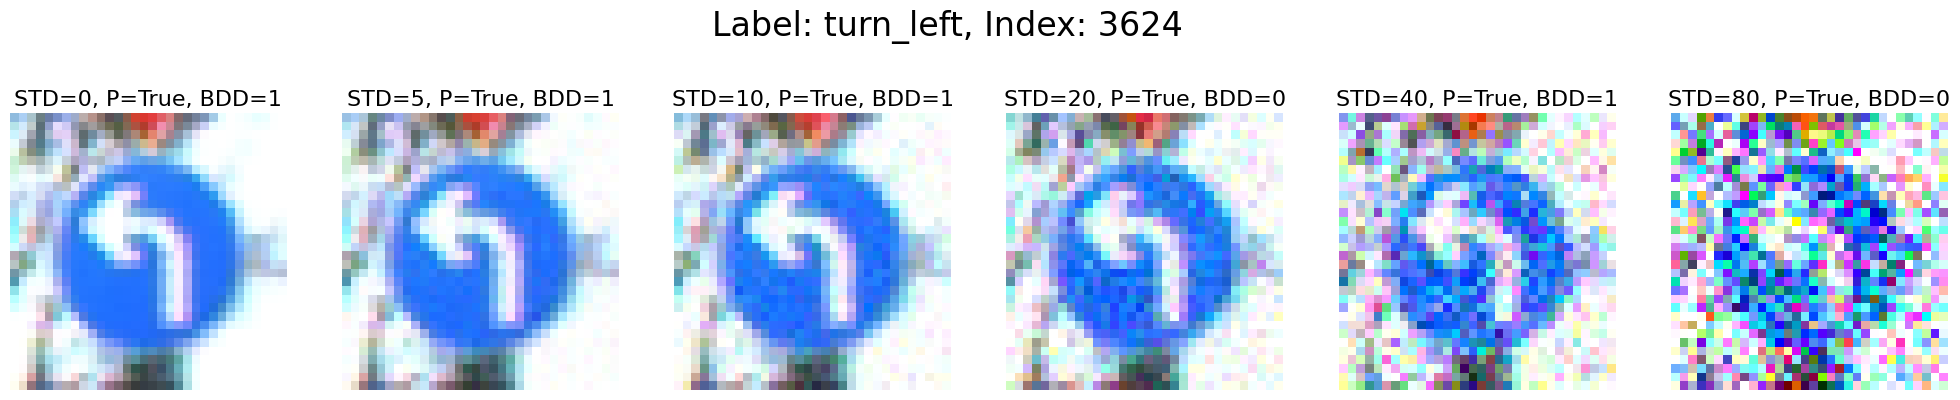

In [122]:
show_image(3)

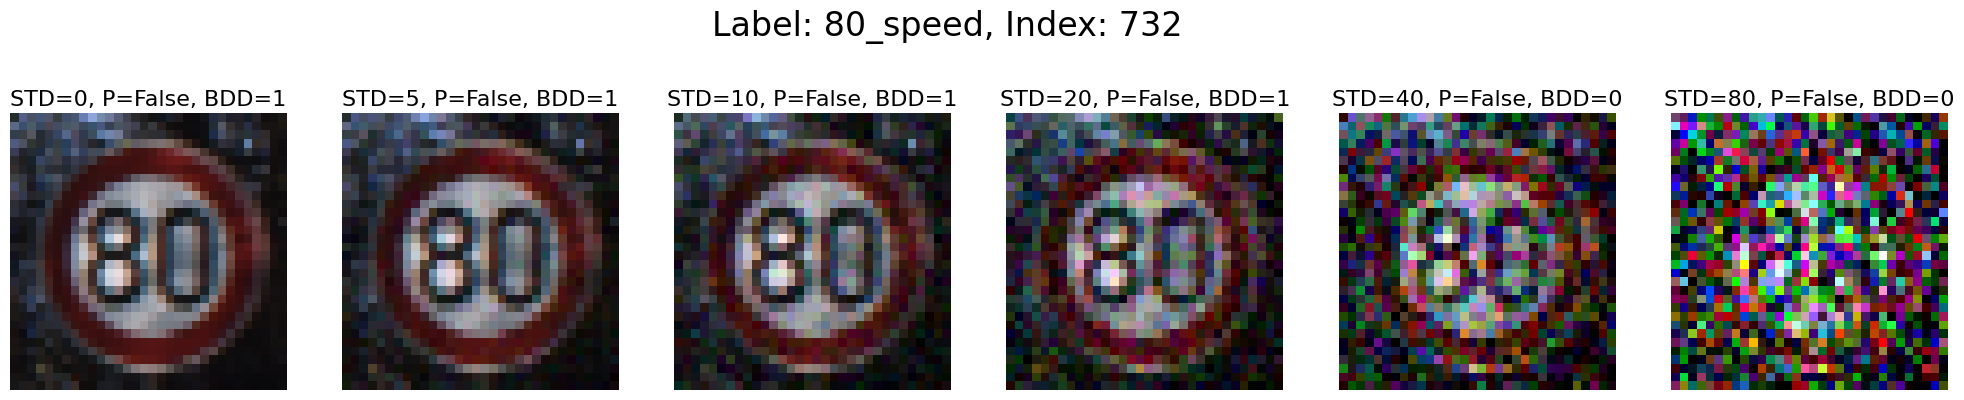

In [123]:
show_image(36)

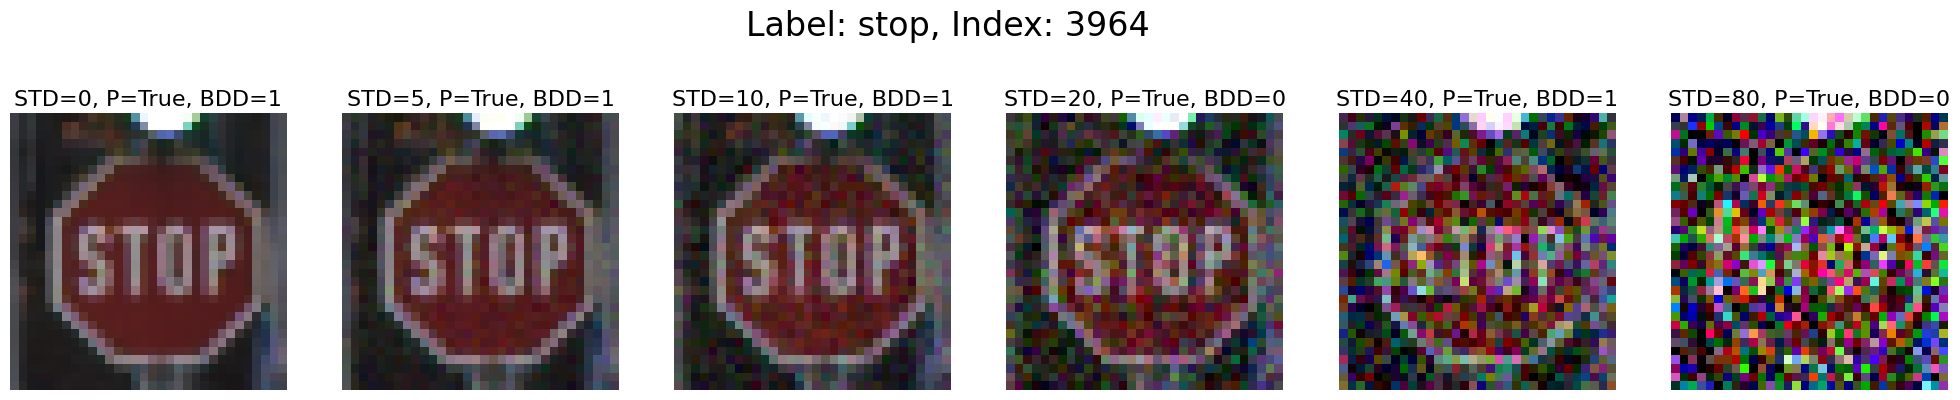

In [125]:
show_image(103)
# show_image(9)

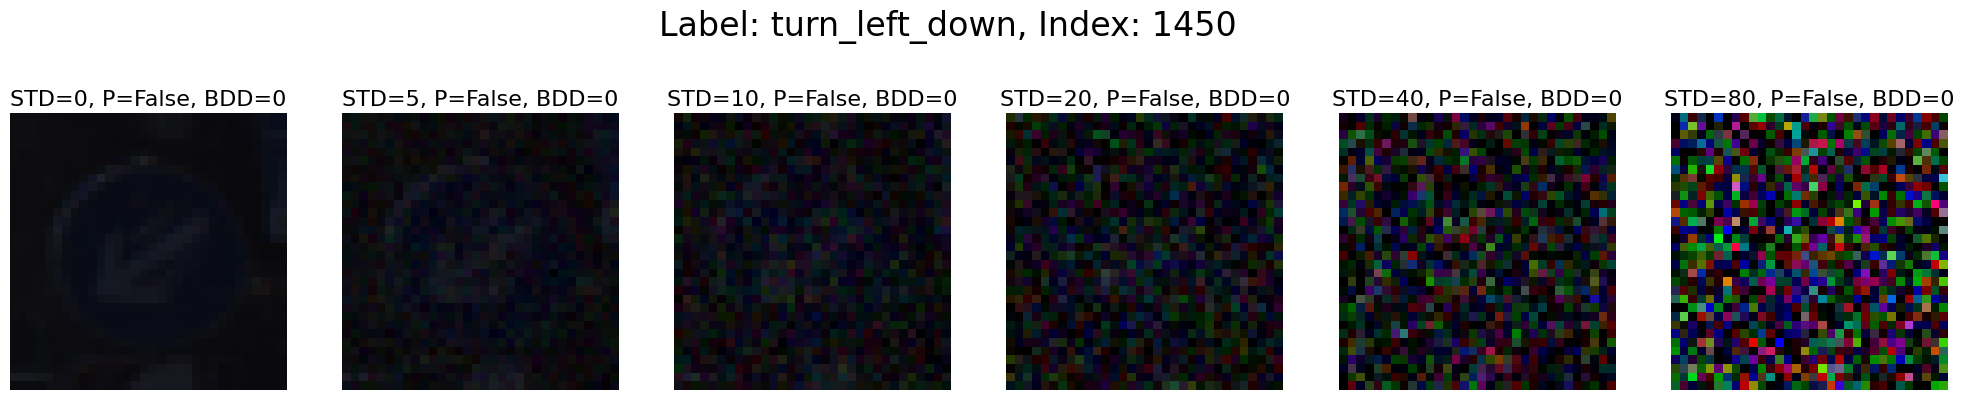

In [127]:
show_image(20)

# Extra Examples

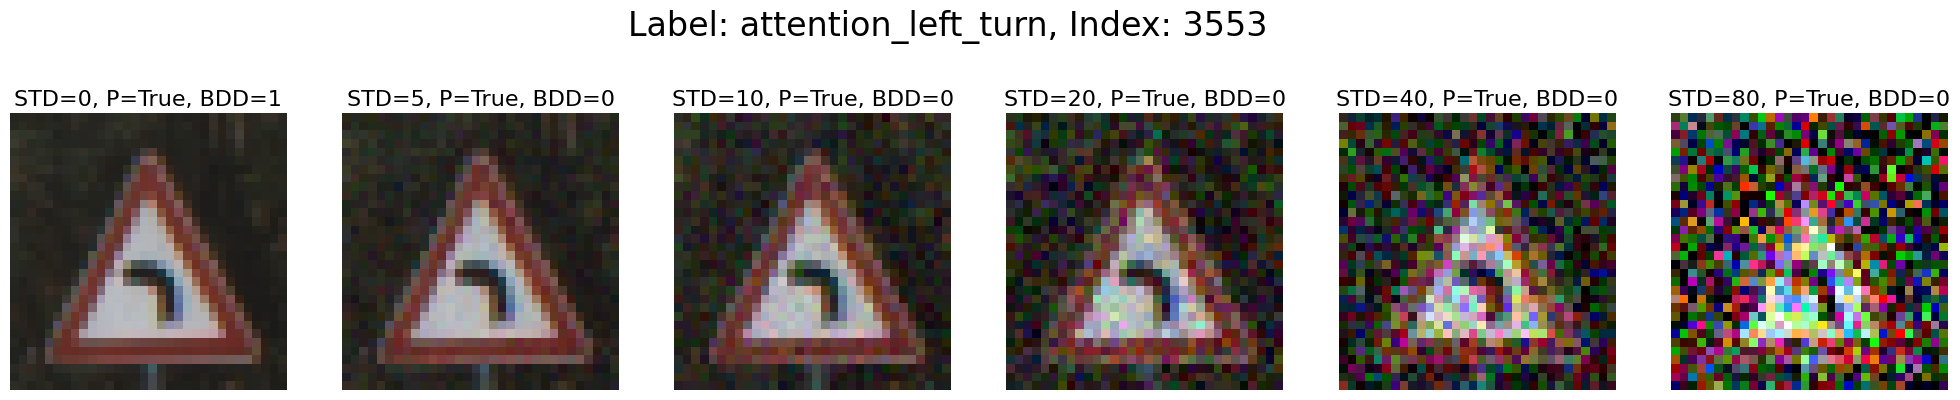

In [143]:
show_image(80)

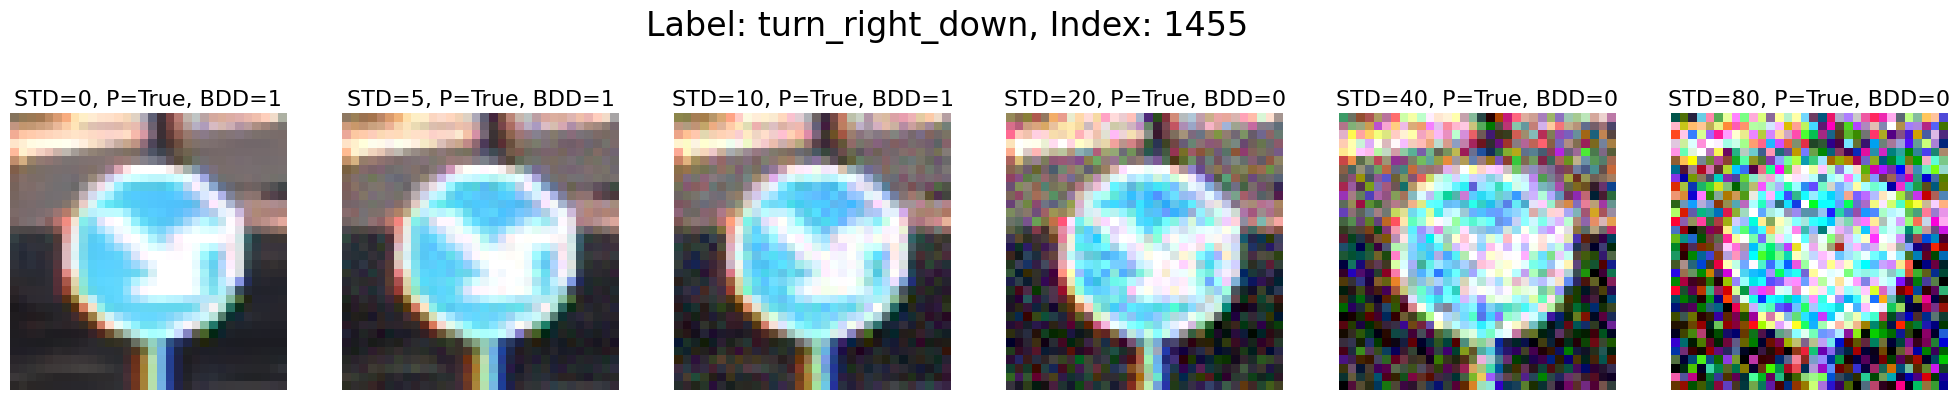

In [144]:
show_image(1)

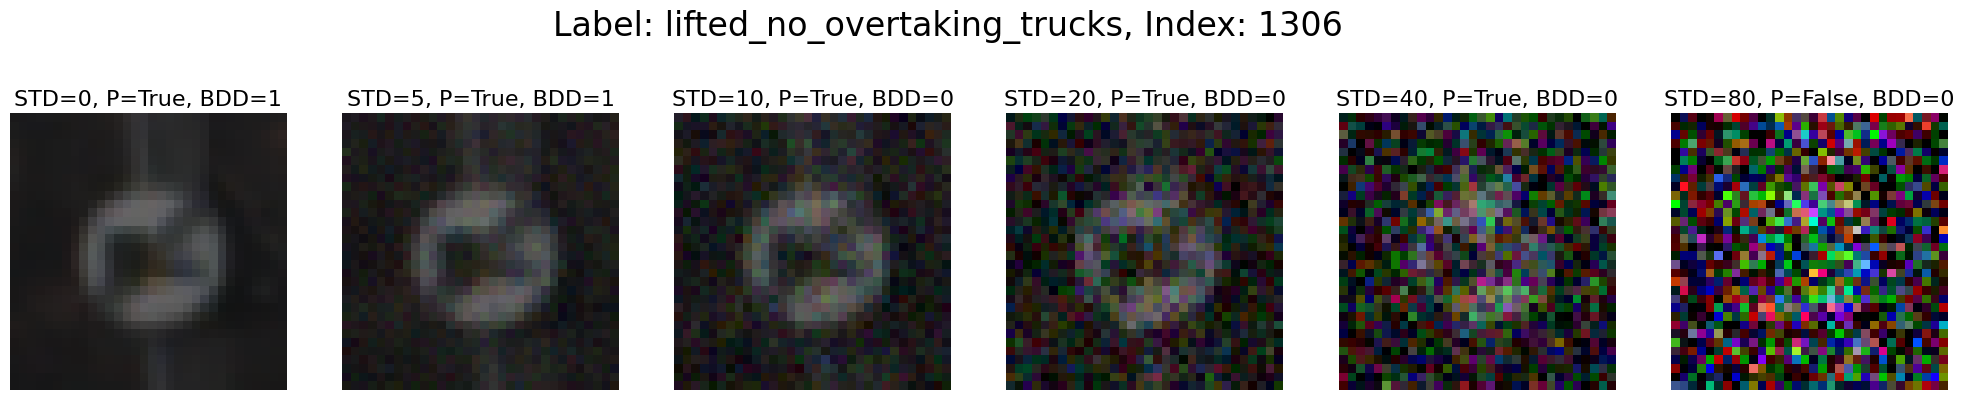

In [145]:
show_image(82)

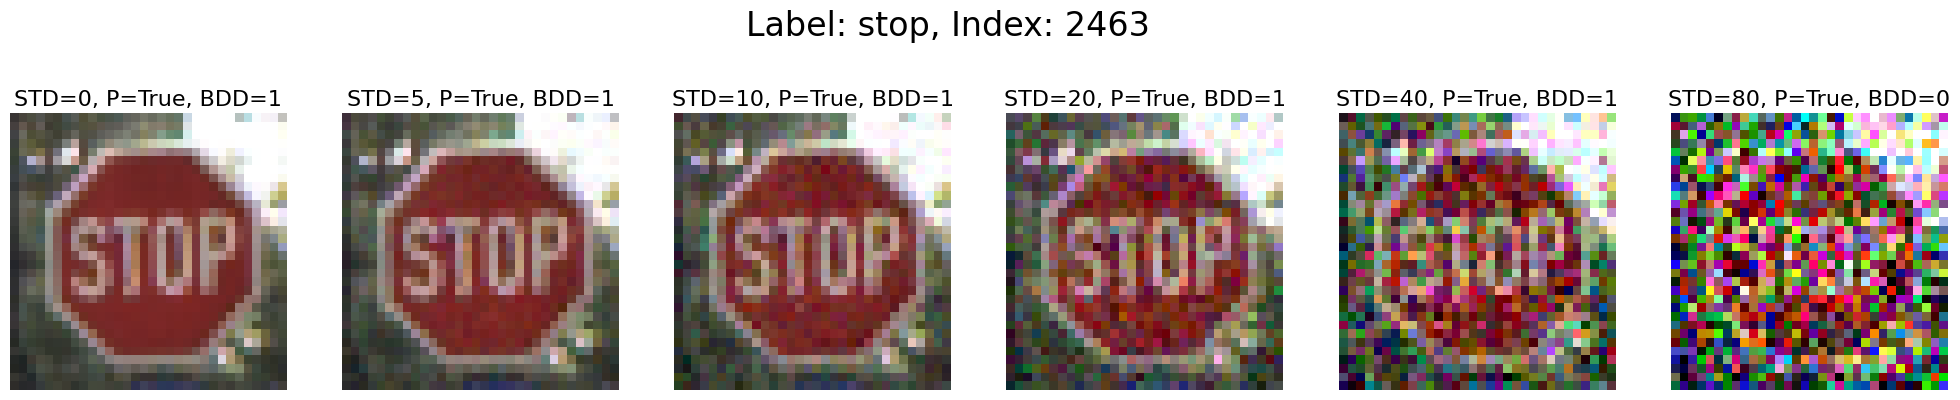

In [146]:
show_image(45)

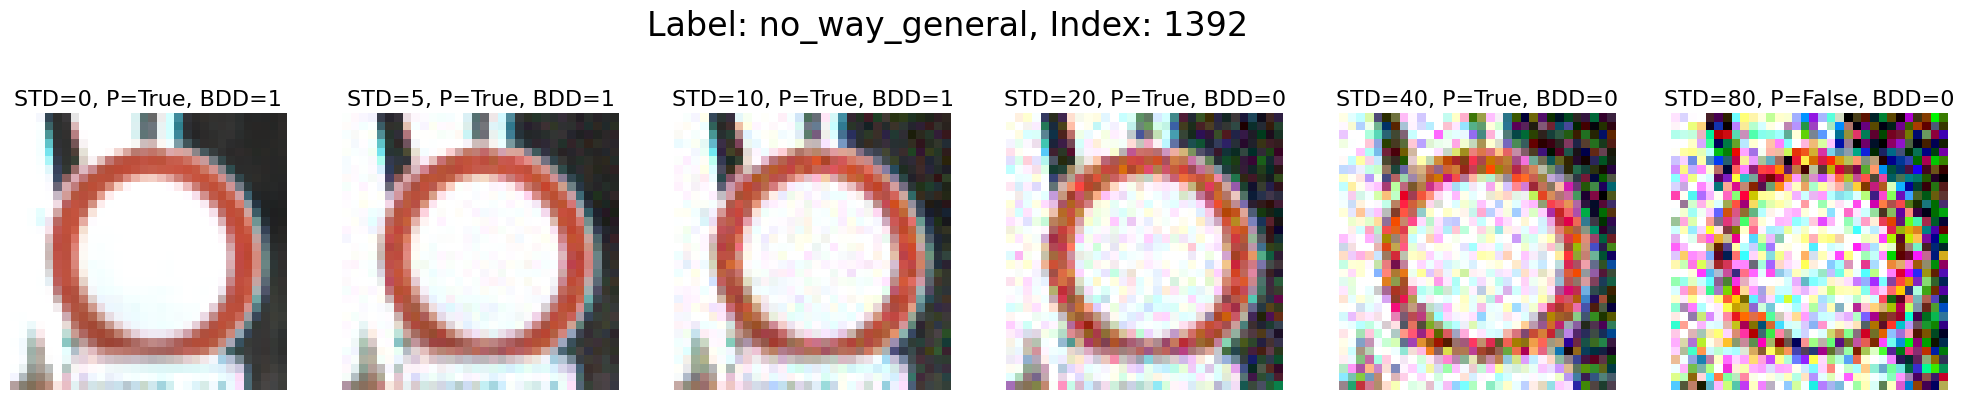

In [147]:
show_image(99)

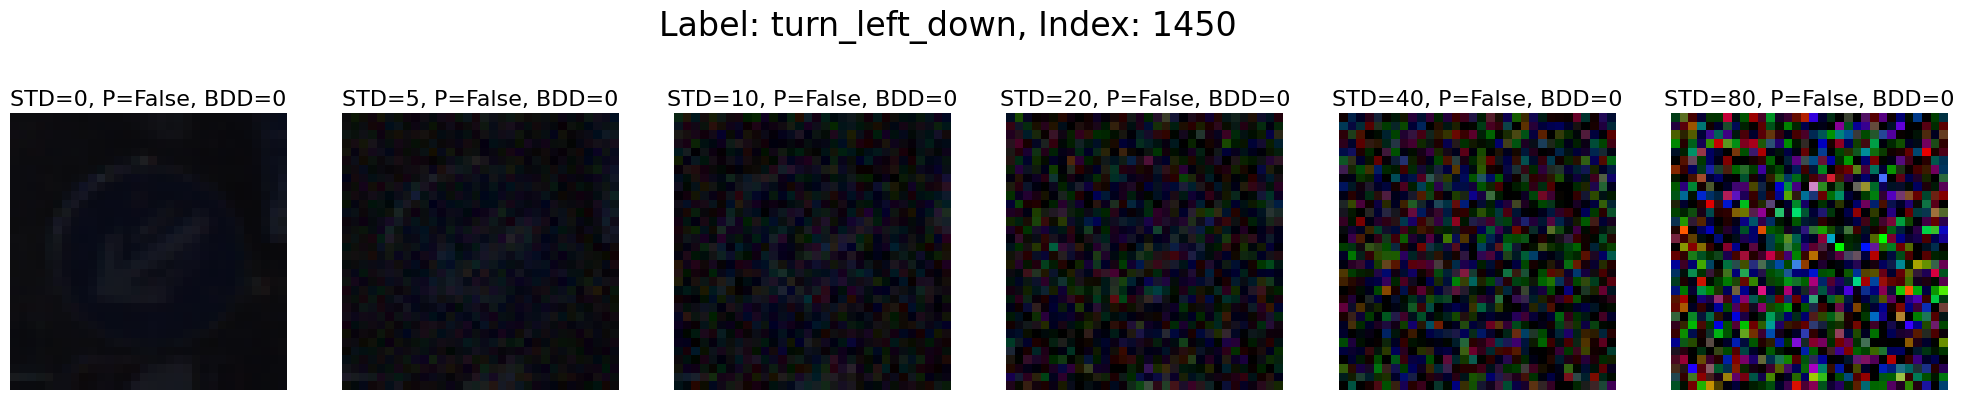

In [149]:
show_image(misclassified[0])

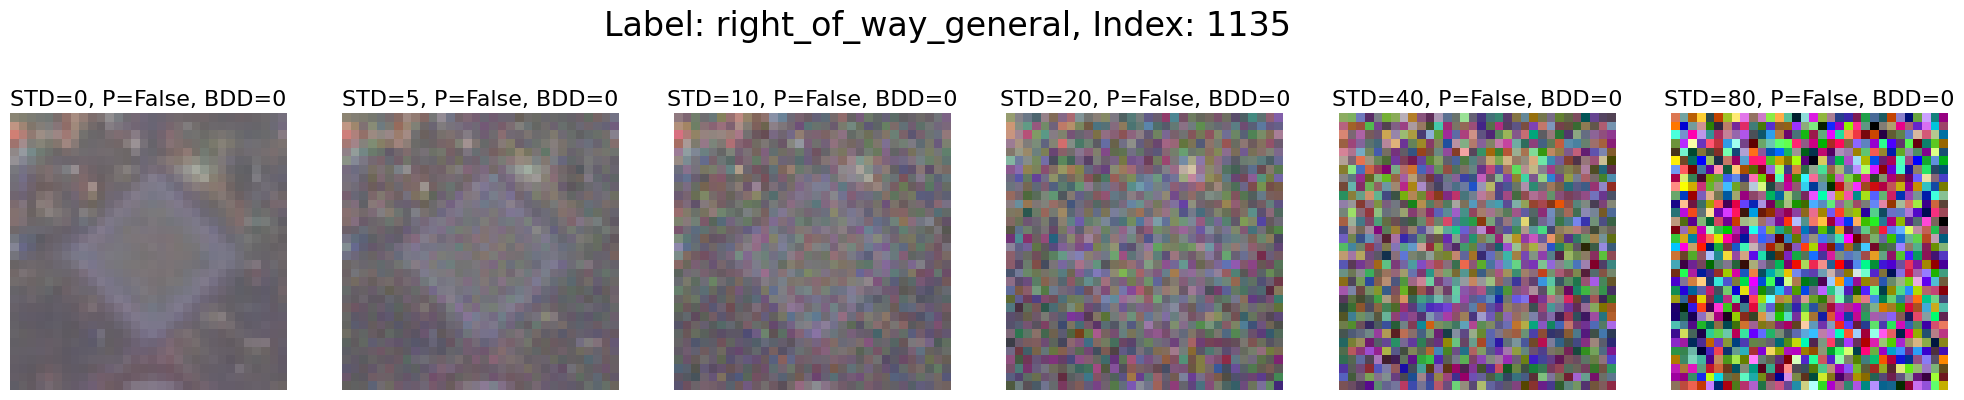

In [150]:
show_image(misclassified[2])

# Data Augmentation

In [105]:
def show_image(id_):
    plt.close('all')

    if DATASET == "GTSRB":
        im = torch.tensor(plt.imread(test_data.root / test_data.data[1][idx[id_]])).permute(2, 0, 1)
    else:
        im = test_data[idx[id_]][0]

    augs = {
        "Original":lambda x: x,
        "Rotation":T.RandomRotation((-45,45)),
        "Crop":T.RandomCrop((32,32), padding=5),
        "VerticalFlip":T.RandomVerticalFlip(p=1),
        "HorizontalFlip":T.RandomHorizontalFlip(p=1),
        "Erasing":T.RandomErasing(p=1)
    }

    test_data_aug = [t(im.type(torch.float32))/255 for t in augs.values()]
    
    x = transformer['test'].transforms[1](torch.stack(test_data_aug))

    logits, pred = model.output_last_layer(x.to(device))
    logits = logits.cpu().numpy()
    pred = pred.argmax(axis=1).cpu().numpy()
    logits = pd.DataFrame(logits, columns=[f'x{i}' for i in range(logits.shape[1])])

    logits['y'] = test_data.data[0][idx[id_]]
    logits['true'] = pred == test_data.data[0][idx[id_]]

    logits_copy = logits.copy()
    patterns.evaluate_dataframe(logits_copy, 0)

    fig, ax = plt.subplots(1, len(augs), figsize=(len(augs)*5, 5))

    for i,(k,m,a) in enumerate(zip(augs.keys(),test_data_aug, ax)):
        a.imshow(m.permute(1, 2, 0))
        a.set_title(f"Aug={k}\nNN={logits_copy['true'][i]}, BDD={logits_copy['bdd_0'][i]}", fontsize=16)
#         a.set_title(f"Aug={k}\nP={logits_copy['true'][i]}", fontsize=16)
        a.axis(False)

    fig.suptitle(f"Label: {feature_names[test_data.data[0][idx[id_]]]}, Index: {idx[id_]}", fontsize=24, y=1.01)
    plt.show()

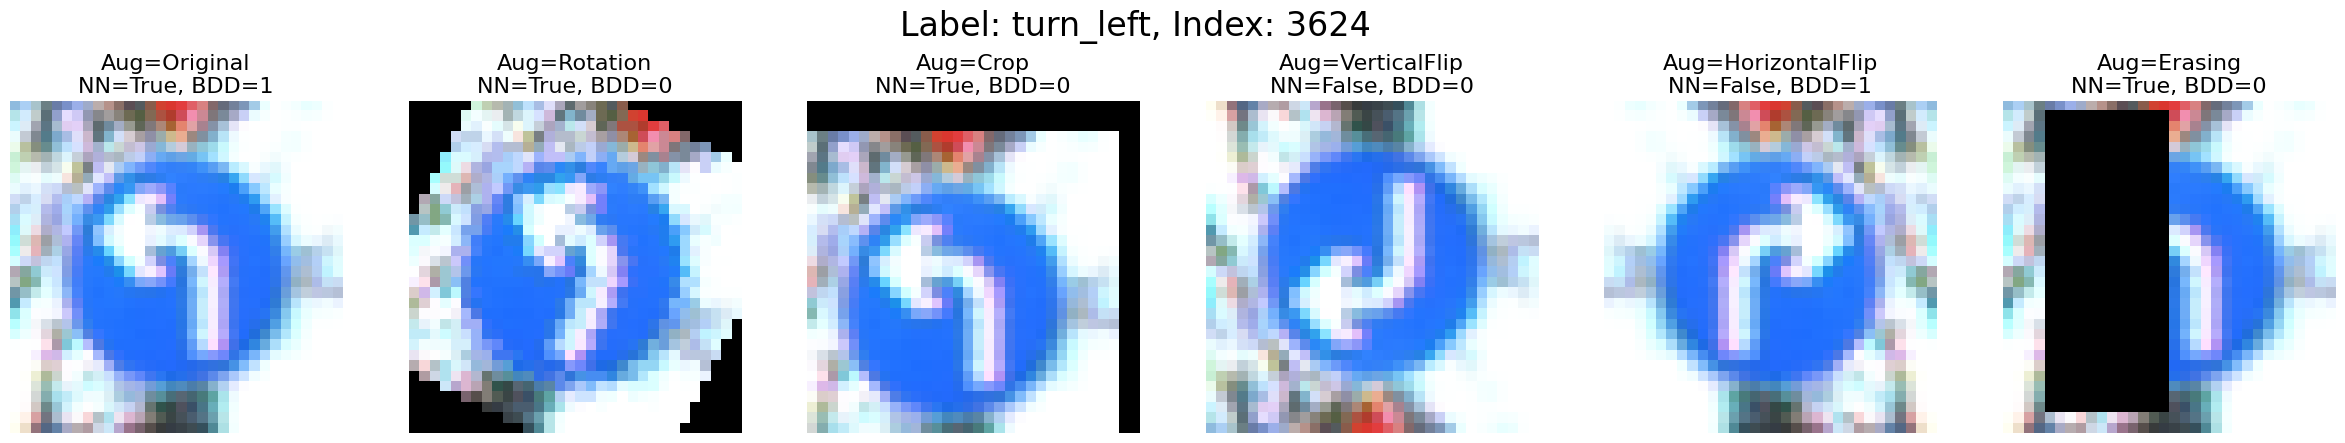

In [108]:
show_image(3)

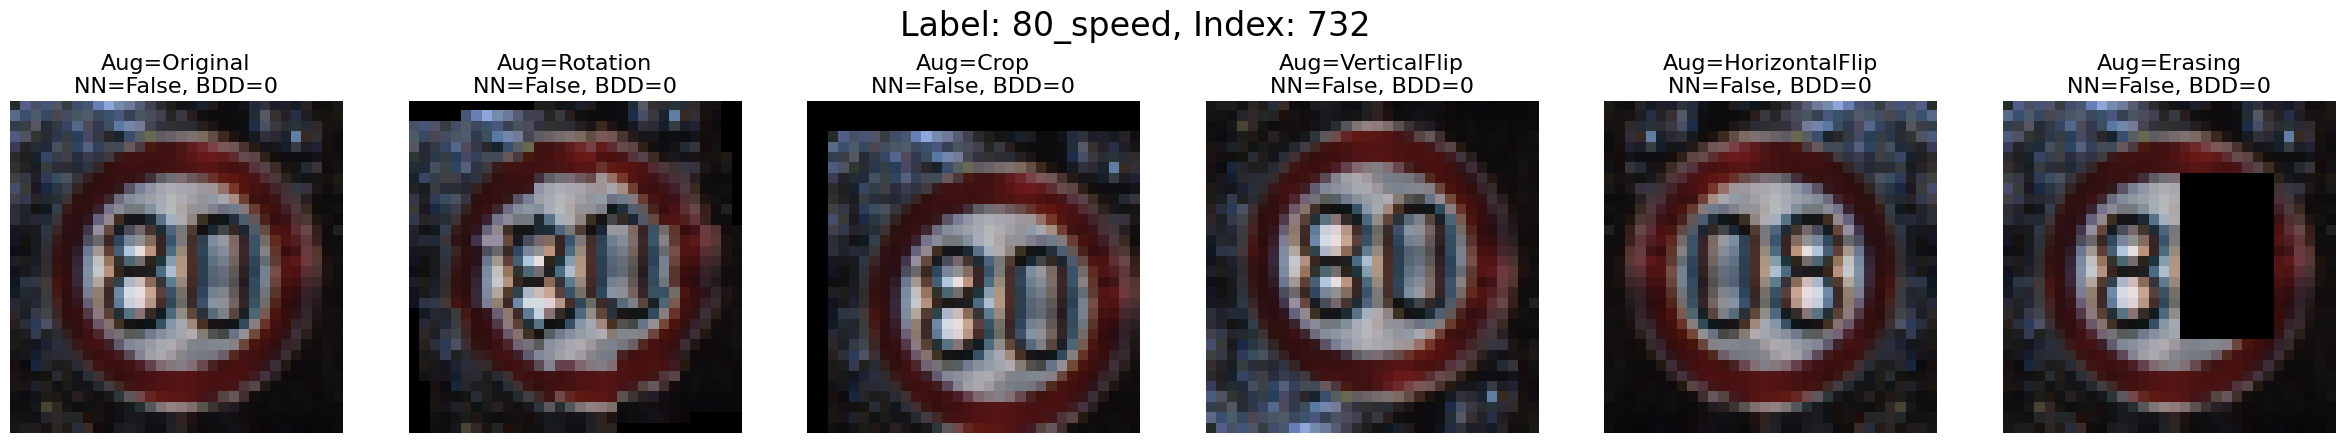

In [114]:
show_image(36)

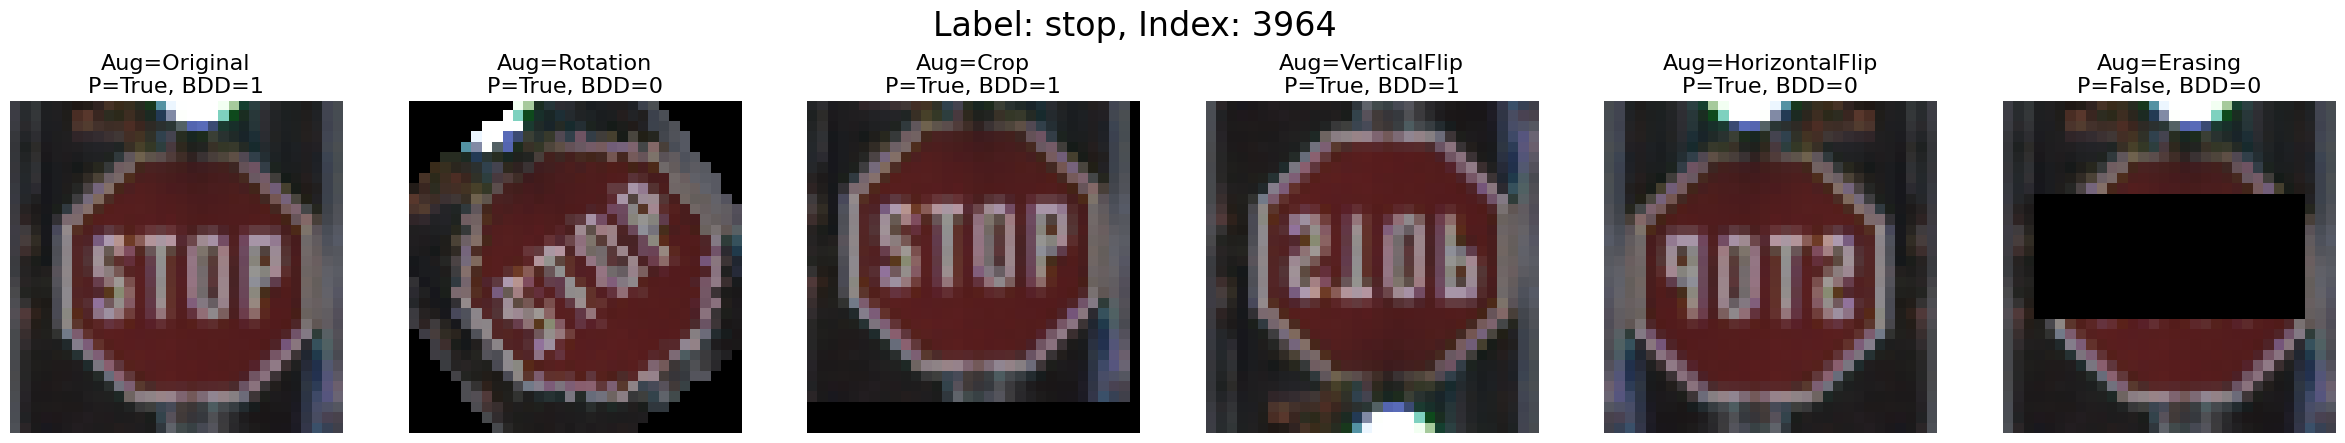

In [62]:
show_image(103)